In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    make_scorer,
    roc_curve,
    auc,
    recall_score,
)

import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from eli5.sklearn import PermutationImportance
import shap
from sklearn.utils.class_weight import compute_class_weight

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-16 13:51:29.624156: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-16 13:51:29.665119: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 13:51:32.520046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tenso

In [2]:
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

In [3]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [4]:
# 데이터 불러오기
train = pd.read_csv('./data/train_0816_variable.csv')
test = pd.read_csv('./data/test_0816_variable.csv')

In [5]:
train.columns

Index(['target', 'inconsistant', 'stage1_dist_cat', 'stage2_dist_cat',
       'stage3_dist_cat', 'cure_time_dam', 'cure_time_fill2',
       'press21_autoclave', 'thon_time', 'discharged_dist_stage1_dam',
       'discharged_dist_stage2_dam', 'discharged_dist_stage3_dam',
       'discharged_dist_stage1_fill1', 'discharged_dist_stage2_fill1',
       'discharged_dist_stage3_fill1', 'fill2_time', 'autoclave_time', 'qty',
       'thick1', 'thick2', 'thick3', 'chamber_temp', 'model_suffix',
       'select_workorder', 'select_pallet', 'direction', 'volume_ratio_stage1',
       'volume_ratio_stage2', 'volume_ratio_stage3'],
      dtype='object')

In [6]:
# 학습시 inconsistant 전부 빼고 적용
train_sel = train[train['inconsistant'] == 0]

In [7]:
# 각 영역별 
stage1 = ['target', 'stage1_dist_cat',
       'cure_time_dam', 'cure_time_fill2', 'thon_time',
       'thick1', 'volume_ratio_stage1',
       'discharged_dist_stage1_dam', 'discharged_dist_stage1_fill1',
       'select_pallet', 'direction'
]

stage2 = [
        'target', 
       'stage2_dist_cat', 
       'cure_time_dam', 'cure_time_fill2', 'thon_time', 
       'thick2', 'volume_ratio_stage2',
       'discharged_dist_stage2_dam', 'discharged_dist_stage2_fill1',
       'select_pallet', 'direction'
]

stage3 = [
        'target', 'stage3_dist_cat',
       'cure_time_dam', 'cure_time_fill2', 'thon_time', 
       'fill2_time', 'thick3', 'volume_ratio_stage3',
       'discharged_dist_stage3_dam', 'discharged_dist_stage3_fill1',
       'select_pallet', 'direction'
]

autoclave = [
        'target',
       'press21_autoclave',
        'autoclave_time', 'select_pallet', 'volume_ratio_stage1',
       'volume_ratio_stage2', 'volume_ratio_stage3', 
       'chamber_temp'
            ]

df_stage1 = train_sel[stage1]
df_stage2 = train_sel[stage2]
df_stage3 = train_sel[stage3]
df_autoclave = train_sel[autoclave]

# Stage1

In [8]:
X_stage1 = df_stage1.drop(columns=['target'])
y_stage1 = df_stage1['target']

cat_features_indices_stage1 = ['select_pallet', 'stage1_dist_cat']

X_train, X_valid, y_train, y_valid = train_test_split(X_stage1, y_stage1, test_size=0.2, random_state=42, stratify = y_stage1)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_stage1)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_stage1)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
                "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
# Sampler 생성 시 random seed 설정
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-16 13:51:38,469] A new study created in memory with name: no-name-be9f58ad-2827-46fc-9f06-f43ec6c3a7b2
[I 2024-08-16 13:51:39,512] Trial 0 finished with value: 0.5218836517140042 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.15702970884055384, 'l2_leaf_reg': 5.990598257128395, 'border_count': 66, 'random_strength': 1.559945204206032, 'bagging_temperature': 0.05808361216819946, 'od_type': 'IncToDec', 'od_wait': 39, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 0 with value: 0.5218836517140042.
[I 2024-08-16 13:51:41,229] Trial 1 finished with value: 0.48565065224307985 and parameters: {'iterations': 291, 'depth': 5, 'learning_rate': 0.0035498788321965025, 'l2_leaf_reg': 3.0493800071657815, 'border_count': 149, 'random_strength': 4.319450186989212, 'bagging_temperature': 0.2912291401980419, 'od_type': 'IncToDec', 'od_wait': 21, 'boosting_type': 'Plain', 'scale_pos_weight': 9}. Best is trial 0 with value: 0.5218836517140042.
[I 2024-08-1

[I 2024-08-16 13:52:01,478] Trial 19 finished with value: 0.5349303145465406 and parameters: {'iterations': 188, 'depth': 9, 'learning_rate': 0.17646797794150668, 'l2_leaf_reg': 5.4851624833083, 'border_count': 56, 'random_strength': 9.08997229294447, 'bagging_temperature': 0.9163887989108709, 'od_type': 'IncToDec', 'od_wait': 29, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 13 with value: 0.5384427423782491.
[I 2024-08-16 13:52:02,061] Trial 20 finished with value: 0.4979969119423979 and parameters: {'iterations': 792, 'depth': 6, 'learning_rate': 0.0854781241700164, 'l2_leaf_reg': 3.1590020313732765, 'border_count': 91, 'random_strength': 6.899277216711631, 'bagging_temperature': 0.7211713774753411, 'od_type': 'IncToDec', 'od_wait': 46, 'boosting_type': 'Plain', 'scale_pos_weight': 7}. Best is trial 13 with value: 0.5384427423782491.
[I 2024-08-16 13:52:02,352] Trial 21 finished with value: 0.5292362105084812 and parameters: {'iterations': 187, 'depth': 9, 'learni

[I 2024-08-16 13:52:11,611] Trial 38 finished with value: 0.498794595176447 and parameters: {'iterations': 488, 'depth': 9, 'learning_rate': 0.42422058433361254, 'l2_leaf_reg': 9.527998784980802, 'border_count': 91, 'random_strength': 7.997944410956883, 'bagging_temperature': 0.8276776554371084, 'od_type': 'Iter', 'od_wait': 47, 'boosting_type': 'Ordered', 'scale_pos_weight': 10}. Best is trial 32 with value: 0.5417462738183654.
[I 2024-08-16 13:52:12,510] Trial 39 finished with value: 0.5127641262873829 and parameters: {'iterations': 295, 'depth': 8, 'learning_rate': 0.026292956030317862, 'l2_leaf_reg': 5.582765829344138, 'border_count': 116, 'random_strength': 4.021856177426778, 'bagging_temperature': 0.9028510847132963, 'od_type': 'IncToDec', 'od_wait': 36, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 32 with value: 0.5417462738183654.
[I 2024-08-16 13:52:12,868] Trial 40 finished with value: 0.5215492577952869 and parameters: {'iterations': 375, 'depth': 6, 'lea

Best trial:
  Value: 0.5417462738183654
  Params: 
    iterations: 159
    depth: 9
    learning_rate: 0.9776018276996896
    l2_leaf_reg: 2.5413686948048473
    border_count: 60
    random_strength: 9.94628329913392
    bagging_temperature: 0.9983049567868356
    od_type: IncToDec
    od_wait: 47
    boosting_type: Plain
    scale_pos_weight: 10


In [9]:
study.best_trial.params

{'iterations': 159,
 'depth': 9,
 'learning_rate': 0.9776018276996896,
 'l2_leaf_reg': 2.5413686948048473,
 'border_count': 60,
 'random_strength': 9.94628329913392,
 'bagging_temperature': 0.9983049567868356,
 'od_type': 'IncToDec',
 'od_wait': 47,
 'boosting_type': 'Plain',
 'scale_pos_weight': 10}

In [10]:
# 최적의 하이퍼파라미터로 모델 재학습
stage1_best_params = study.best_trial.params
stage1_best_model = CatBoostClassifier(random_state = 42, **stage1_best_params)
stage1_best_model.fit(X_train, y_train, cat_features=cat_features_indices_stage1)

0:	learn: 0.6515547	total: 2.05ms	remaining: 324ms
1:	learn: 0.6440359	total: 4.89ms	remaining: 384ms
2:	learn: 0.6415888	total: 7.44ms	remaining: 387ms
3:	learn: 0.6391473	total: 10ms	remaining: 387ms
4:	learn: 0.6369489	total: 12.7ms	remaining: 393ms
5:	learn: 0.6364492	total: 14.6ms	remaining: 372ms
6:	learn: 0.6364500	total: 15.6ms	remaining: 340ms
7:	learn: 0.6346923	total: 18.4ms	remaining: 347ms
8:	learn: 0.6340155	total: 21.1ms	remaining: 352ms
9:	learn: 0.6326449	total: 23.7ms	remaining: 352ms
10:	learn: 0.6324643	total: 25.2ms	remaining: 339ms
11:	learn: 0.6314017	total: 27.9ms	remaining: 342ms
12:	learn: 0.6293781	total: 30.4ms	remaining: 341ms
13:	learn: 0.6287211	total: 32.8ms	remaining: 340ms
14:	learn: 0.6248362	total: 35.6ms	remaining: 342ms
15:	learn: 0.6221816	total: 38.4ms	remaining: 343ms
16:	learn: 0.6203725	total: 41.1ms	remaining: 343ms
17:	learn: 0.6182099	total: 43.7ms	remaining: 342ms
18:	learn: 0.6151556	total: 46.6ms	remaining: 343ms
19:	learn: 0.6140281	tot

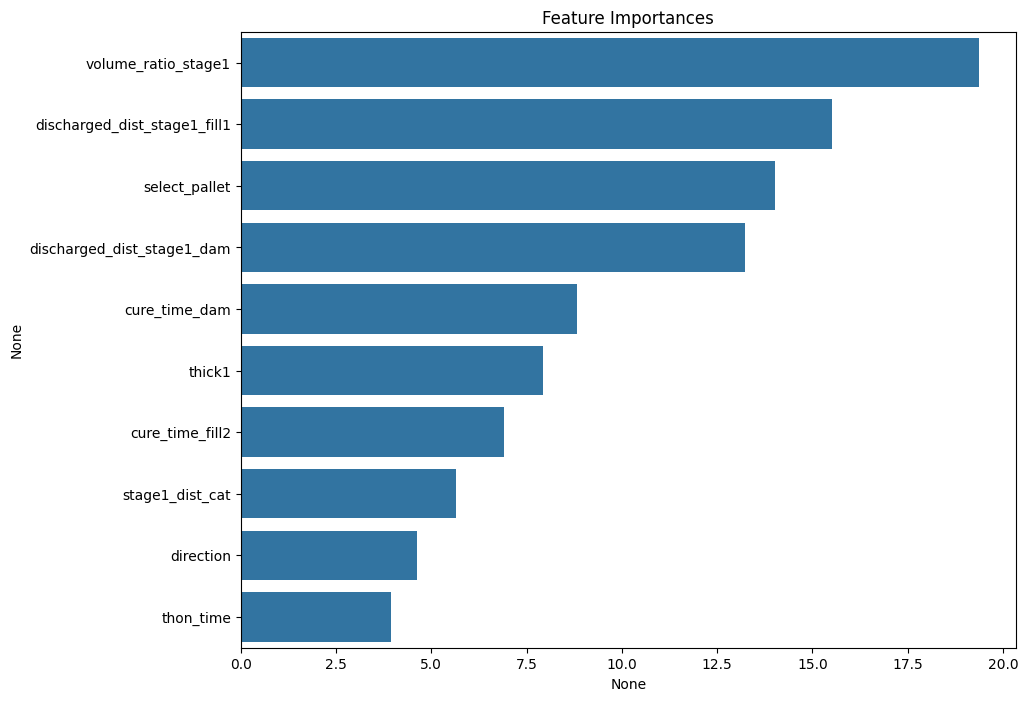

In [11]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(stage1_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [12]:
pred = stage1_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  94  357]
 [ 850 6782]]

정확도: 0.8507
정밀도: 0.0996
재현율: 0.2084
F1: 0.1348


# Stage2

In [13]:
X_stage2 = df_stage2.drop(columns=['target'])
y_stage2 = df_stage2['target']

cat_features_indices_stage2 = ['select_pallet', 'stage2_dist_cat']

X_train, X_valid, y_train, y_valid = train_test_split(X_stage2, y_stage2, test_size=0.2, random_state=42, stratify = y_stage2)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_stage2)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_stage2)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-16 13:52:19,101] A new study created in memory with name: no-name-859fb186-1c70-4b4e-bec0-991e422f1af5
[I 2024-08-16 13:52:20,477] Trial 0 finished with value: 0.5374235520687368 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.15702970884055384, 'l2_leaf_reg': 5.990598257128395, 'border_count': 66, 'random_strength': 1.559945204206032, 'bagging_temperature': 0.05808361216819946, 'od_type': 'IncToDec', 'od_wait': 39, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 0 with value: 0.5374235520687368.
[I 2024-08-16 13:52:23,044] Trial 1 finished with value: 0.48565065224307985 and parameters: {'iterations': 291, 'depth': 5, 'learning_rate': 0.0035498788321965025, 'l2_leaf_reg': 3.0493800071657815, 'border_count': 149, 'random_strength': 4.319450186989212, 'bagging_temperature': 0.2912291401980419, 'od_type': 'IncToDec', 'od_wait': 21, 'boosting_type': 'Plain', 'scale_pos_weight': 9}. Best is trial 0 with value: 0.5374235520687368.
[I 2024-08-1

[I 2024-08-16 13:53:14,763] Trial 19 finished with value: 0.5251058927733745 and parameters: {'iterations': 346, 'depth': 7, 'learning_rate': 0.48201827304342254, 'l2_leaf_reg': 9.586413907417107, 'border_count': 91, 'random_strength': 5.626619621518348, 'bagging_temperature': 0.39452860258021505, 'od_type': 'IncToDec', 'od_wait': 26, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 10 with value: 0.5390717197866928.
[I 2024-08-16 13:53:15,504] Trial 20 finished with value: 0.4920686638725716 and parameters: {'iterations': 179, 'depth': 9, 'learning_rate': 0.09328116216577248, 'l2_leaf_reg': 4.997881940659671, 'border_count': 50, 'random_strength': 9.019813786313106, 'bagging_temperature': 0.6501272229348498, 'od_type': 'IncToDec', 'od_wait': 35, 'boosting_type': 'Plain', 'scale_pos_weight': 7}. Best is trial 10 with value: 0.5390717197866928.
[I 2024-08-16 13:53:18,485] Trial 21 finished with value: 0.5337821919442798 and parameters: {'iterations': 921, 'depth': 6, 'le

[I 2024-08-16 13:54:12,691] Trial 38 finished with value: 0.5178153711582556 and parameters: {'iterations': 505, 'depth': 4, 'learning_rate': 0.3850541212736142, 'l2_leaf_reg': 3.1137916065795634, 'border_count': 70, 'random_strength': 0.6387428815036301, 'bagging_temperature': 0.1438410307907224, 'od_type': 'Iter', 'od_wait': 36, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 10 with value: 0.5390717197866928.
[I 2024-08-16 13:54:14,256] Trial 39 finished with value: 0.5324264486243556 and parameters: {'iterations': 268, 'depth': 7, 'learning_rate': 0.2338577003113793, 'l2_leaf_reg': 3.7613127041990464, 'border_count': 97, 'random_strength': 4.469131648371255, 'bagging_temperature': 0.444624840373124, 'od_type': 'Iter', 'od_wait': 24, 'boosting_type': 'Ordered', 'scale_pos_weight': 10}. Best is trial 10 with value: 0.5390717197866928.
[I 2024-08-16 13:54:18,775] Trial 40 finished with value: 0.48565065224307985 and parameters: {'iterations': 356, 'depth': 10, 'learni

Best trial:
  Value: 0.5390717197866928
  Params: 
    iterations: 138
    depth: 8
    learning_rate: 0.810235620776663
    l2_leaf_reg: 3.8004058211423
    border_count: 35
    random_strength: 9.076647952917511
    bagging_temperature: 0.9597707459454197
    od_type: IncToDec
    od_wait: 49
    boosting_type: Plain
    scale_pos_weight: 10


In [14]:
study.best_trial.params

{'iterations': 138,
 'depth': 8,
 'learning_rate': 0.810235620776663,
 'l2_leaf_reg': 3.8004058211423,
 'border_count': 35,
 'random_strength': 9.076647952917511,
 'bagging_temperature': 0.9597707459454197,
 'od_type': 'IncToDec',
 'od_wait': 49,
 'boosting_type': 'Plain',
 'scale_pos_weight': 10}

In [15]:
# 최적의 하이퍼파라미터로 모델 재학습
stage2_best_params = study.best_trial.params
stage2_best_model = CatBoostClassifier(random_state = 42, **stage2_best_params)
stage2_best_model.fit(X_train, y_train, cat_features=cat_features_indices_stage2)

0:	learn: 0.6487780	total: 4.88ms	remaining: 668ms
1:	learn: 0.6467403	total: 9.36ms	remaining: 636ms
2:	learn: 0.6446941	total: 12.9ms	remaining: 582ms
3:	learn: 0.6446859	total: 15ms	remaining: 502ms
4:	learn: 0.6415492	total: 19.1ms	remaining: 508ms
5:	learn: 0.6414663	total: 22.6ms	remaining: 497ms
6:	learn: 0.6393391	total: 26.7ms	remaining: 499ms
7:	learn: 0.6392501	total: 29.1ms	remaining: 473ms
8:	learn: 0.6364160	total: 33.4ms	remaining: 479ms
9:	learn: 0.6358738	total: 36.5ms	remaining: 467ms
10:	learn: 0.6358694	total: 39ms	remaining: 451ms
11:	learn: 0.6334833	total: 43.3ms	remaining: 454ms
12:	learn: 0.6331580	total: 46.1ms	remaining: 443ms
13:	learn: 0.6329615	total: 50.1ms	remaining: 444ms
14:	learn: 0.6322772	total: 54.3ms	remaining: 445ms
15:	learn: 0.6322771	total: 56.5ms	remaining: 431ms
16:	learn: 0.6306482	total: 60.6ms	remaining: 431ms
17:	learn: 0.6297309	total: 64.9ms	remaining: 433ms
18:	learn: 0.6288855	total: 68.9ms	remaining: 432ms
19:	learn: 0.6269160	total

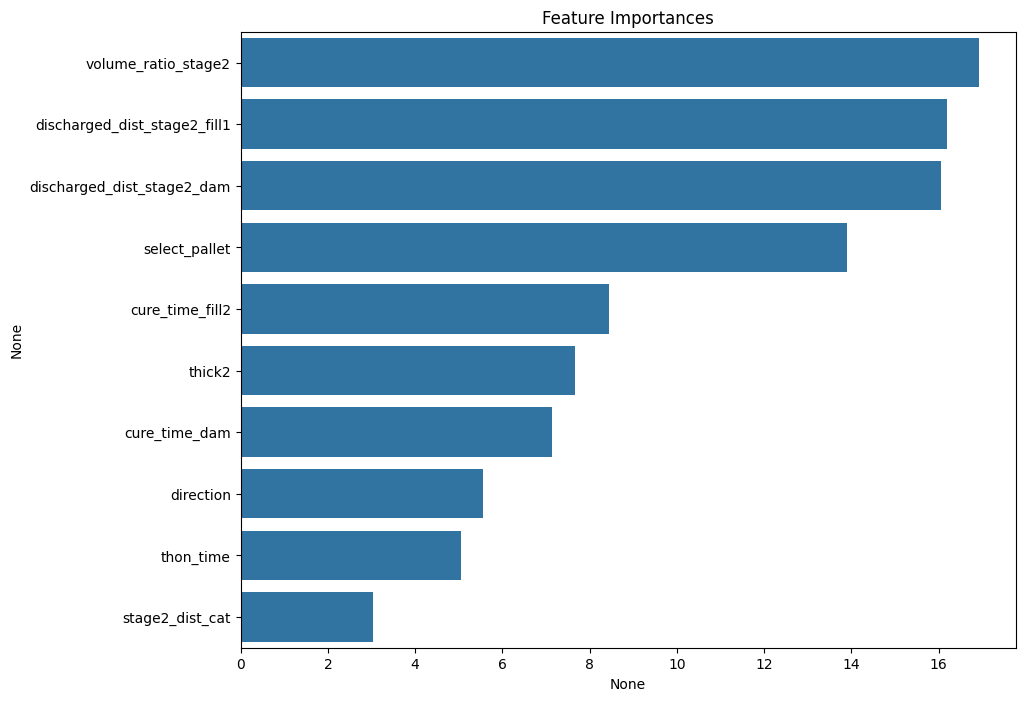

In [16]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(stage2_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [17]:
pred = stage2_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  81  370]
 [ 915 6717]]

정확도: 0.8410
정밀도: 0.0813
재현율: 0.1796
F1: 0.1120


# Stage3

In [18]:
X_stage3 = df_stage3.drop(columns=['target'])
y_stage3 = df_stage3['target']

cat_features_indices_stage3 = ['select_pallet', 'stage3_dist_cat']

X_train, X_valid, y_train, y_valid = train_test_split(X_stage3, y_stage3, test_size=0.2, random_state=42, stratify = y_stage3)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_stage3)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_stage3)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-16 13:54:55,867] A new study created in memory with name: no-name-73e1de96-0299-4bf7-8aed-bed8cd926630
[I 2024-08-16 13:54:56,444] Trial 0 finished with value: 0.5268540702405858 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.15702970884055384, 'l2_leaf_reg': 5.990598257128395, 'border_count': 66, 'random_strength': 1.559945204206032, 'bagging_temperature': 0.05808361216819946, 'od_type': 'IncToDec', 'od_wait': 39, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 0 with value: 0.5268540702405858.
[I 2024-08-16 13:54:57,434] Trial 1 finished with value: 0.48565065224307985 and parameters: {'iterations': 291, 'depth': 5, 'learning_rate': 0.0035498788321965025, 'l2_leaf_reg': 3.0493800071657815, 'border_count': 149, 'random_strength': 4.319450186989212, 'bagging_temperature': 0.2912291401980419, 'od_type': 'IncToDec', 'od_wait': 21, 'boosting_type': 'Plain', 'scale_pos_weight': 9}. Best is trial 0 with value: 0.5268540702405858.
[I 2024-08-1

[I 2024-08-16 13:55:23,955] Trial 19 finished with value: 0.5244530181714763 and parameters: {'iterations': 640, 'depth': 6, 'learning_rate': 0.0817699436657431, 'l2_leaf_reg': 9.586413907417107, 'border_count': 85, 'random_strength': 3.8430833235085897, 'bagging_temperature': 0.7296134204123256, 'od_type': 'IncToDec', 'od_wait': 33, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 12 with value: 0.5287787257803662.
[I 2024-08-16 13:55:25,866] Trial 20 finished with value: 0.487706039813551 and parameters: {'iterations': 522, 'depth': 9, 'learning_rate': 0.017528114829507294, 'l2_leaf_reg': 6.997383214717969, 'border_count': 188, 'random_strength': 7.875839926095371, 'bagging_temperature': 0.8731984928288521, 'od_type': 'IncToDec', 'od_wait': 16, 'boosting_type': 'Plain', 'scale_pos_weight': 7}. Best is trial 12 with value: 0.5287787257803662.
[I 2024-08-16 13:55:26,221] Trial 21 finished with value: 0.5258292908497311 and parameters: {'iterations': 198, 'depth': 9, 'le

[I 2024-08-16 13:55:39,950] Trial 38 finished with value: 0.5252337934790902 and parameters: {'iterations': 569, 'depth': 5, 'learning_rate': 0.4039074058126716, 'l2_leaf_reg': 4.065502019427342, 'border_count': 139, 'random_strength': 2.2543856749570246, 'bagging_temperature': 0.7312456655666758, 'od_type': 'Iter', 'od_wait': 42, 'boosting_type': 'Ordered', 'scale_pos_weight': 10}. Best is trial 36 with value: 0.5338223270000609.
[I 2024-08-16 13:55:40,235] Trial 39 finished with value: 0.5249433068857876 and parameters: {'iterations': 782, 'depth': 6, 'learning_rate': 0.9185431669744814, 'l2_leaf_reg': 3.3341079491357903, 'border_count': 159, 'random_strength': 0.4485784831198113, 'bagging_temperature': 0.8267439550675582, 'od_type': 'IncToDec', 'od_wait': 45, 'boosting_type': 'Plain', 'scale_pos_weight': 9}. Best is trial 36 with value: 0.5338223270000609.
[I 2024-08-16 13:55:42,630] Trial 40 finished with value: 0.5021374554059126 and parameters: {'iterations': 866, 'depth': 7, 'le

Best trial:
  Value: 0.5338223270000609
  Params: 
    iterations: 609
    depth: 6
    learning_rate: 0.49145795913430135
    l2_leaf_reg: 5.027777361038444
    border_count: 133
    random_strength: 0.9118081503614053
    bagging_temperature: 0.6444959340768984
    od_type: IncToDec
    od_wait: 43
    boosting_type: Plain
    scale_pos_weight: 10


In [19]:
study.best_trial.params

{'iterations': 609,
 'depth': 6,
 'learning_rate': 0.49145795913430135,
 'l2_leaf_reg': 5.027777361038444,
 'border_count': 133,
 'random_strength': 0.9118081503614053,
 'bagging_temperature': 0.6444959340768984,
 'od_type': 'IncToDec',
 'od_wait': 43,
 'boosting_type': 'Plain',
 'scale_pos_weight': 10}

In [20]:
# 최적의 하이퍼파라미터로 모델 재학습
stage3_best_params = study.best_trial.params
stage3_best_model = CatBoostClassifier(random_state = 42, **stage3_best_params)
stage3_best_model.fit(X_train, y_train, cat_features=cat_features_indices_stage3)

0:	learn: 0.6582064	total: 3.72ms	remaining: 2.26s
1:	learn: 0.6486061	total: 6.84ms	remaining: 2.08s
2:	learn: 0.6411483	total: 10.4ms	remaining: 2.1s
3:	learn: 0.6392312	total: 13.9ms	remaining: 2.1s
4:	learn: 0.6374734	total: 16.8ms	remaining: 2.02s
5:	learn: 0.6359481	total: 20.3ms	remaining: 2.04s
6:	learn: 0.6346219	total: 23.9ms	remaining: 2.05s
7:	learn: 0.6334503	total: 27.4ms	remaining: 2.06s
8:	learn: 0.6319996	total: 31.1ms	remaining: 2.07s
9:	learn: 0.6307242	total: 34.6ms	remaining: 2.07s
10:	learn: 0.6293749	total: 38.2ms	remaining: 2.08s
11:	learn: 0.6280527	total: 41.9ms	remaining: 2.08s
12:	learn: 0.6273854	total: 45.4ms	remaining: 2.08s
13:	learn: 0.6261656	total: 49.1ms	remaining: 2.08s
14:	learn: 0.6252449	total: 52.6ms	remaining: 2.08s
15:	learn: 0.6251250	total: 55.1ms	remaining: 2.04s
16:	learn: 0.6248206	total: 58.5ms	remaining: 2.04s
17:	learn: 0.6239986	total: 62.1ms	remaining: 2.04s
18:	learn: 0.6232669	total: 65.7ms	remaining: 2.04s
19:	learn: 0.6227868	tot

168:	learn: 0.5229615	total: 608ms	remaining: 1.58s
169:	learn: 0.5228604	total: 612ms	remaining: 1.58s
170:	learn: 0.5225691	total: 615ms	remaining: 1.58s
171:	learn: 0.5225054	total: 619ms	remaining: 1.57s
172:	learn: 0.5223971	total: 622ms	remaining: 1.57s
173:	learn: 0.5222959	total: 626ms	remaining: 1.56s
174:	learn: 0.5218787	total: 630ms	remaining: 1.56s
175:	learn: 0.5213521	total: 633ms	remaining: 1.56s
176:	learn: 0.5209635	total: 637ms	remaining: 1.55s
177:	learn: 0.5205371	total: 641ms	remaining: 1.55s
178:	learn: 0.5202894	total: 644ms	remaining: 1.55s
179:	learn: 0.5202165	total: 648ms	remaining: 1.54s
180:	learn: 0.5197274	total: 652ms	remaining: 1.54s
181:	learn: 0.5194813	total: 656ms	remaining: 1.54s
182:	learn: 0.5192994	total: 659ms	remaining: 1.53s
183:	learn: 0.5189840	total: 663ms	remaining: 1.53s
184:	learn: 0.5186453	total: 667ms	remaining: 1.53s
185:	learn: 0.5182211	total: 670ms	remaining: 1.52s
186:	learn: 0.5180407	total: 674ms	remaining: 1.52s
187:	learn: 

331:	learn: 0.4929842	total: 1.21s	remaining: 1.01s
332:	learn: 0.4928965	total: 1.21s	remaining: 1s
333:	learn: 0.4927125	total: 1.22s	remaining: 1s
334:	learn: 0.4925521	total: 1.22s	remaining: 998ms
335:	learn: 0.4923633	total: 1.22s	remaining: 995ms
336:	learn: 0.4922828	total: 1.23s	remaining: 992ms
337:	learn: 0.4920750	total: 1.23s	remaining: 988ms
338:	learn: 0.4920169	total: 1.24s	remaining: 985ms
339:	learn: 0.4919235	total: 1.24s	remaining: 981ms
340:	learn: 0.4917821	total: 1.24s	remaining: 978ms
341:	learn: 0.4917541	total: 1.25s	remaining: 974ms
342:	learn: 0.4915882	total: 1.25s	remaining: 970ms
343:	learn: 0.4915514	total: 1.25s	remaining: 967ms
344:	learn: 0.4914791	total: 1.26s	remaining: 963ms
345:	learn: 0.4914674	total: 1.26s	remaining: 960ms
346:	learn: 0.4914300	total: 1.27s	remaining: 956ms
347:	learn: 0.4912708	total: 1.27s	remaining: 952ms
348:	learn: 0.4911317	total: 1.27s	remaining: 949ms
349:	learn: 0.4909619	total: 1.28s	remaining: 945ms
350:	learn: 0.4909

496:	learn: 0.4786706	total: 1.81s	remaining: 407ms
497:	learn: 0.4786317	total: 1.81s	remaining: 404ms
498:	learn: 0.4785772	total: 1.82s	remaining: 400ms
499:	learn: 0.4785638	total: 1.82s	remaining: 397ms
500:	learn: 0.4784934	total: 1.82s	remaining: 393ms
501:	learn: 0.4784859	total: 1.83s	remaining: 389ms
502:	learn: 0.4783133	total: 1.83s	remaining: 386ms
503:	learn: 0.4782710	total: 1.83s	remaining: 382ms
504:	learn: 0.4781851	total: 1.84s	remaining: 379ms
505:	learn: 0.4781573	total: 1.84s	remaining: 375ms
506:	learn: 0.4781275	total: 1.84s	remaining: 371ms
507:	learn: 0.4781151	total: 1.85s	remaining: 368ms
508:	learn: 0.4780846	total: 1.85s	remaining: 364ms
509:	learn: 0.4779896	total: 1.86s	remaining: 360ms
510:	learn: 0.4779648	total: 1.86s	remaining: 357ms
511:	learn: 0.4778649	total: 1.86s	remaining: 353ms
512:	learn: 0.4778173	total: 1.87s	remaining: 349ms
513:	learn: 0.4777357	total: 1.87s	remaining: 346ms
514:	learn: 0.4776902	total: 1.87s	remaining: 342ms
515:	learn: 

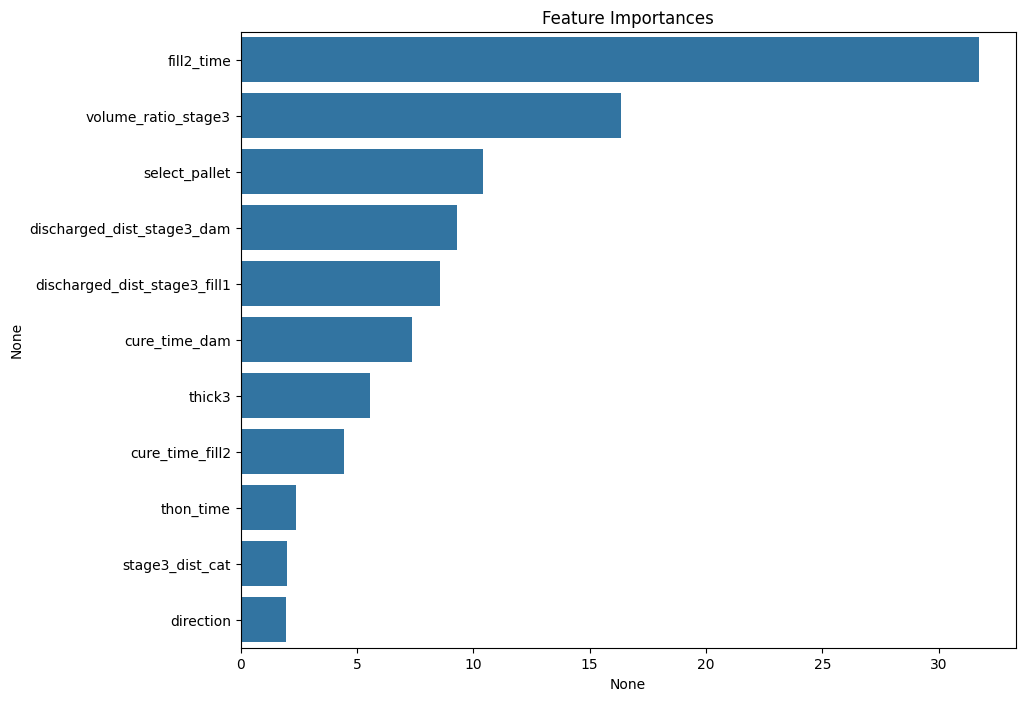

In [21]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(stage3_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [22]:
pred = stage3_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[ 100  351]
 [1066 6566]]

정확도: 0.8247
정밀도: 0.0858
재현율: 0.2217
F1: 0.1237


# AutoClave

In [23]:
X_AutoClave = df_autoclave.drop(columns=['target'])
y_AutoClave = df_autoclave['target']

cat_features_indices_autoclave = ['select_pallet', 'chamber_temp']

X_train, X_valid, y_train, y_valid = train_test_split(X_AutoClave, y_AutoClave, test_size=0.2, random_state=42, stratify = y_AutoClave)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_autoclave)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_autoclave)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-16 13:55:50,313] A new study created in memory with name: no-name-507a9b06-3706-4aae-9d2a-10db853252a5
[I 2024-08-16 13:55:51,642] Trial 0 finished with value: 0.5209199511837309 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.15702970884055384, 'l2_leaf_reg': 5.990598257128395, 'border_count': 66, 'random_strength': 1.559945204206032, 'bagging_temperature': 0.05808361216819946, 'od_type': 'IncToDec', 'od_wait': 39, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 0 with value: 0.5209199511837309.
[I 2024-08-16 13:55:54,206] Trial 1 finished with value: 0.49211562556305816 and parameters: {'iterations': 291, 'depth': 5, 'learning_rate': 0.0035498788321965025, 'l2_leaf_reg': 3.0493800071657815, 'border_count': 149, 'random_strength': 4.319450186989212, 'bagging_temperature': 0.2912291401980419, 'od_type': 'IncToDec', 'od_wait': 21, 'boosting_type': 'Plain', 'scale_pos_weight': 9}. Best is trial 0 with value: 0.5209199511837309.
[I 2024-08-1

[I 2024-08-16 13:57:30,491] Trial 19 finished with value: 0.4899155771876039 and parameters: {'iterations': 100, 'depth': 9, 'learning_rate': 0.007195471349108276, 'l2_leaf_reg': 3.9721166616066252, 'border_count': 128, 'random_strength': 9.496289214196345, 'bagging_temperature': 0.4080763594696553, 'od_type': 'IncToDec', 'od_wait': 35, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 13 with value: 0.5399605008471597.
[I 2024-08-16 13:57:35,602] Trial 20 finished with value: 0.4958742194469224 and parameters: {'iterations': 575, 'depth': 6, 'learning_rate': 0.017528114829507294, 'l2_leaf_reg': 5.233883472880459, 'border_count': 49, 'random_strength': 1.190435750580702, 'bagging_temperature': 0.8134174575589901, 'od_type': 'IncToDec', 'od_wait': 40, 'boosting_type': 'Plain', 'scale_pos_weight': 7}. Best is trial 13 with value: 0.5399605008471597.
[I 2024-08-16 13:57:40,315] Trial 21 finished with value: 0.5306054321382966 and parameters: {'iterations': 769, 'depth': 8, 

[I 2024-08-16 13:58:15,394] Trial 38 finished with value: 0.4997293233881593 and parameters: {'iterations': 248, 'depth': 4, 'learning_rate': 0.14335651088484597, 'l2_leaf_reg': 9.391549859288876, 'border_count': 132, 'random_strength': 0.5963822364792597, 'bagging_temperature': 0.5013117792687107, 'od_type': 'Iter', 'od_wait': 22, 'boosting_type': 'Ordered', 'scale_pos_weight': 10}. Best is trial 29 with value: 0.5461607332544235.
[I 2024-08-16 13:58:17,478] Trial 39 finished with value: 0.5296587337176399 and parameters: {'iterations': 348, 'depth': 10, 'learning_rate': 0.2338577003113793, 'l2_leaf_reg': 7.938973679428513, 'border_count': 179, 'random_strength': 4.0123233173847135, 'bagging_temperature': 0.8911342372405981, 'od_type': 'IncToDec', 'od_wait': 38, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 29 with value: 0.5461607332544235.
[I 2024-08-16 13:58:18,014] Trial 40 finished with value: 0.4992898464876639 and parameters: {'iterations': 109, 'depth': 9, '

Best trial:
  Value: 0.5461607332544235
  Params: 
    iterations: 379
    depth: 5
    learning_rate: 0.13320837586981674
    l2_leaf_reg: 9.7407013710575
    border_count: 84
    random_strength: 1.6395336156628493
    bagging_temperature: 0.4906783824962769
    od_type: IncToDec
    od_wait: 28
    boosting_type: Plain
    scale_pos_weight: 10


In [24]:
study.best_trial.params

{'iterations': 379,
 'depth': 5,
 'learning_rate': 0.13320837586981674,
 'l2_leaf_reg': 9.7407013710575,
 'border_count': 84,
 'random_strength': 1.6395336156628493,
 'bagging_temperature': 0.4906783824962769,
 'od_type': 'IncToDec',
 'od_wait': 28,
 'boosting_type': 'Plain',
 'scale_pos_weight': 10}

In [25]:
# 최적의 하이퍼파라미터로 모델 재학습
AutoClave_best_params = study.best_trial.params
AutoClave_best_model = CatBoostClassifier(random_state = 42, **AutoClave_best_params)
AutoClave_best_model.fit(X_train, y_train, cat_features=cat_features_indices_autoclave)

0:	learn: 0.6799091	total: 11.3ms	remaining: 4.27s
1:	learn: 0.6712249	total: 20.5ms	remaining: 3.87s
2:	learn: 0.6641892	total: 30.7ms	remaining: 3.84s
3:	learn: 0.6590292	total: 39ms	remaining: 3.66s
4:	learn: 0.6551142	total: 50.2ms	remaining: 3.76s
5:	learn: 0.6517037	total: 60.3ms	remaining: 3.75s
6:	learn: 0.6495960	total: 70.2ms	remaining: 3.73s
7:	learn: 0.6477291	total: 80.2ms	remaining: 3.72s
8:	learn: 0.6464363	total: 89.6ms	remaining: 3.68s
9:	learn: 0.6455233	total: 98.5ms	remaining: 3.63s
10:	learn: 0.6445811	total: 107ms	remaining: 3.59s
11:	learn: 0.6435760	total: 117ms	remaining: 3.57s
12:	learn: 0.6429887	total: 126ms	remaining: 3.56s
13:	learn: 0.6422653	total: 137ms	remaining: 3.56s
14:	learn: 0.6419776	total: 146ms	remaining: 3.55s
15:	learn: 0.6411587	total: 156ms	remaining: 3.54s
16:	learn: 0.6408211	total: 166ms	remaining: 3.53s
17:	learn: 0.6406089	total: 176ms	remaining: 3.54s
18:	learn: 0.6405638	total: 181ms	remaining: 3.44s
19:	learn: 0.6404007	total: 190ms

167:	learn: 0.6117019	total: 1.6s	remaining: 2s
168:	learn: 0.6114941	total: 1.61s	remaining: 2s
169:	learn: 0.6111015	total: 1.62s	remaining: 1.99s
170:	learn: 0.6107214	total: 1.63s	remaining: 1.98s
171:	learn: 0.6105082	total: 1.64s	remaining: 1.97s
172:	learn: 0.6102708	total: 1.65s	remaining: 1.96s
173:	learn: 0.6100057	total: 1.66s	remaining: 1.96s
174:	learn: 0.6098975	total: 1.67s	remaining: 1.95s
175:	learn: 0.6096210	total: 1.68s	remaining: 1.94s
176:	learn: 0.6096100	total: 1.69s	remaining: 1.93s
177:	learn: 0.6094829	total: 1.7s	remaining: 1.92s
178:	learn: 0.6094396	total: 1.71s	remaining: 1.91s
179:	learn: 0.6093532	total: 1.72s	remaining: 1.9s
180:	learn: 0.6092940	total: 1.73s	remaining: 1.89s
181:	learn: 0.6092859	total: 1.74s	remaining: 1.88s
182:	learn: 0.6090525	total: 1.75s	remaining: 1.87s
183:	learn: 0.6089586	total: 1.76s	remaining: 1.86s
184:	learn: 0.6086841	total: 1.77s	remaining: 1.85s
185:	learn: 0.6082622	total: 1.78s	remaining: 1.84s
186:	learn: 0.6079431

329:	learn: 0.5889601	total: 3.22s	remaining: 479ms
330:	learn: 0.5889123	total: 3.23s	remaining: 469ms
331:	learn: 0.5886820	total: 3.24s	remaining: 459ms
332:	learn: 0.5885914	total: 3.25s	remaining: 449ms
333:	learn: 0.5885063	total: 3.26s	remaining: 440ms
334:	learn: 0.5884729	total: 3.27s	remaining: 430ms
335:	learn: 0.5884511	total: 3.28s	remaining: 420ms
336:	learn: 0.5884048	total: 3.29s	remaining: 411ms
337:	learn: 0.5883090	total: 3.3s	remaining: 401ms
338:	learn: 0.5882084	total: 3.31s	remaining: 391ms
339:	learn: 0.5879946	total: 3.32s	remaining: 381ms
340:	learn: 0.5879495	total: 3.33s	remaining: 372ms
341:	learn: 0.5876360	total: 3.35s	remaining: 362ms
342:	learn: 0.5875428	total: 3.35s	remaining: 352ms
343:	learn: 0.5874774	total: 3.37s	remaining: 342ms
344:	learn: 0.5873794	total: 3.37s	remaining: 333ms
345:	learn: 0.5872528	total: 3.38s	remaining: 323ms
346:	learn: 0.5871900	total: 3.4s	remaining: 313ms
347:	learn: 0.5871563	total: 3.4s	remaining: 303ms
348:	learn: 0.5

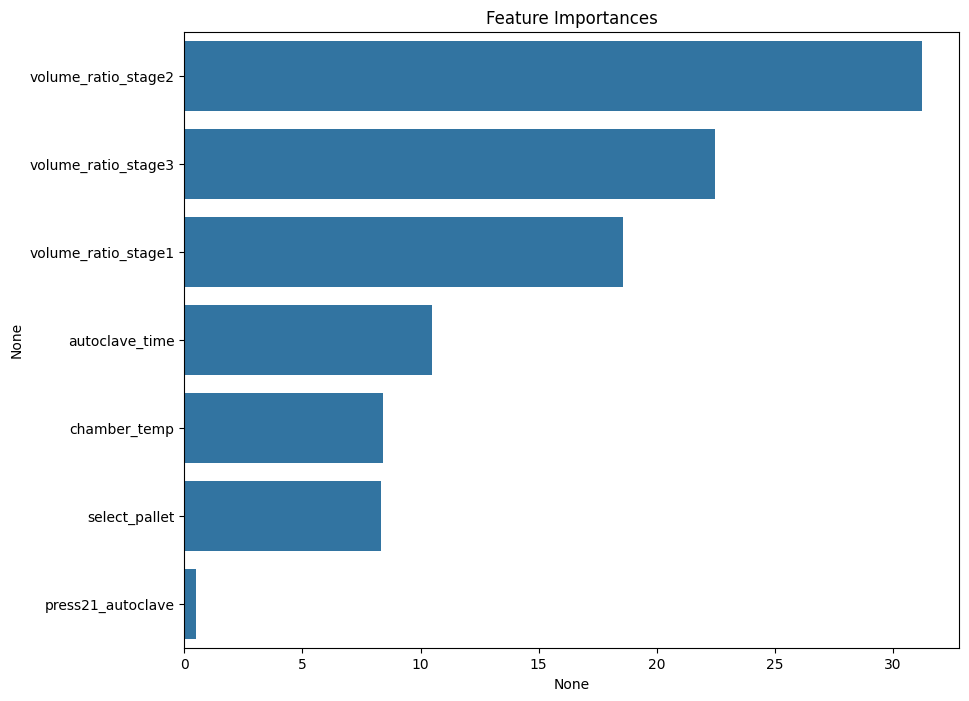

In [26]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(AutoClave_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [27]:
pred = AutoClave_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  87  364]
 [ 714 6918]]

정확도: 0.8666
정밀도: 0.1086
재현율: 0.1929
F1: 0.1390


# 민감성

In [28]:
# 최적의 하이퍼파라미터로 모델 재학습
stage1_best_params = stage1_best_params
stage1_best_model = CatBoostClassifier(random_state = 42, **stage1_best_params)
stage1_best_model.fit(X_stage1, y_stage1, cat_features=cat_features_indices_stage1)

# 최적의 하이퍼파라미터로 모델 재학습
stage2_best_params = stage2_best_params
stage2_best_model = CatBoostClassifier(random_state = 42, **stage2_best_params)
stage2_best_model.fit(X_stage2, y_stage2, cat_features=cat_features_indices_stage2)

# 최적의 하이퍼파라미터로 모델 재학습
stage3_best_params = stage3_best_params
stage3_best_model = CatBoostClassifier(random_state = 42, **stage3_best_params)
stage3_best_model.fit(X_stage3, y_stage3, cat_features=cat_features_indices_stage3)

# 최적의 하이퍼파라미터로 모델 재학습
AutoClave_best_params = AutoClave_best_params
AutoClave_best_model = CatBoostClassifier(random_state = 42, **AutoClave_best_params)
AutoClave_best_model.fit(X_AutoClave, y_AutoClave, cat_features=cat_features_indices_autoclave)

0:	learn: 0.6484999	total: 2.35ms	remaining: 371ms
1:	learn: 0.6441288	total: 5.84ms	remaining: 458ms
2:	learn: 0.6409528	total: 9.12ms	remaining: 474ms
3:	learn: 0.6387626	total: 12.5ms	remaining: 484ms
4:	learn: 0.6358725	total: 15.2ms	remaining: 468ms
5:	learn: 0.6351165	total: 18.6ms	remaining: 473ms
6:	learn: 0.6351043	total: 20.1ms	remaining: 436ms
7:	learn: 0.6349330	total: 23ms	remaining: 433ms
8:	learn: 0.6322398	total: 26.3ms	remaining: 438ms
9:	learn: 0.6295968	total: 29.6ms	remaining: 441ms
10:	learn: 0.6274004	total: 33.1ms	remaining: 445ms
11:	learn: 0.6255932	total: 36.4ms	remaining: 446ms
12:	learn: 0.6251619	total: 39.6ms	remaining: 444ms
13:	learn: 0.6236091	total: 42.7ms	remaining: 443ms
14:	learn: 0.6220120	total: 45.9ms	remaining: 441ms
15:	learn: 0.6206452	total: 49.2ms	remaining: 440ms
16:	learn: 0.6195809	total: 52.5ms	remaining: 438ms
17:	learn: 0.6184744	total: 55.7ms	remaining: 436ms
18:	learn: 0.6170093	total: 58.8ms	remaining: 434ms
19:	learn: 0.6150065	tot

0:	learn: 0.6487612	total: 6.19ms	remaining: 848ms
1:	learn: 0.6446285	total: 10.8ms	remaining: 736ms
2:	learn: 0.6445481	total: 14.2ms	remaining: 640ms
3:	learn: 0.6406083	total: 19.3ms	remaining: 646ms
4:	learn: 0.6406064	total: 21.6ms	remaining: 574ms
5:	learn: 0.6405589	total: 25ms	remaining: 549ms
6:	learn: 0.6387999	total: 30ms	remaining: 561ms
7:	learn: 0.6386165	total: 33.6ms	remaining: 546ms
8:	learn: 0.6386146	total: 37.6ms	remaining: 539ms
9:	learn: 0.6373022	total: 43ms	remaining: 551ms
10:	learn: 0.6371313	total: 46.1ms	remaining: 532ms
11:	learn: 0.6370907	total: 49.3ms	remaining: 518ms
12:	learn: 0.6369440	total: 52.8ms	remaining: 508ms
13:	learn: 0.6368519	total: 56.4ms	remaining: 499ms
14:	learn: 0.6368518	total: 58.6ms	remaining: 481ms
15:	learn: 0.6352417	total: 63.6ms	remaining: 485ms
16:	learn: 0.6333926	total: 68.3ms	remaining: 486ms
17:	learn: 0.6299671	total: 73.6ms	remaining: 491ms
18:	learn: 0.6275774	total: 78.6ms	remaining: 493ms
19:	learn: 0.6253835	total: 

24:	learn: 0.6190539	total: 106ms	remaining: 2.47s
25:	learn: 0.6182484	total: 110ms	remaining: 2.47s
26:	learn: 0.6172397	total: 114ms	remaining: 2.46s
27:	learn: 0.6161524	total: 119ms	remaining: 2.46s
28:	learn: 0.6152361	total: 123ms	remaining: 2.46s
29:	learn: 0.6140271	total: 127ms	remaining: 2.46s
30:	learn: 0.6136776	total: 132ms	remaining: 2.45s
31:	learn: 0.6129140	total: 136ms	remaining: 2.45s
32:	learn: 0.6118307	total: 140ms	remaining: 2.45s
33:	learn: 0.6104300	total: 145ms	remaining: 2.44s
34:	learn: 0.6097252	total: 149ms	remaining: 2.44s
35:	learn: 0.6084847	total: 153ms	remaining: 2.44s
36:	learn: 0.6072213	total: 157ms	remaining: 2.43s
37:	learn: 0.6063743	total: 162ms	remaining: 2.43s
38:	learn: 0.6050709	total: 166ms	remaining: 2.43s
39:	learn: 0.6034242	total: 171ms	remaining: 2.43s
40:	learn: 0.6017490	total: 175ms	remaining: 2.43s
41:	learn: 0.6008703	total: 179ms	remaining: 2.42s
42:	learn: 0.6002248	total: 184ms	remaining: 2.42s
43:	learn: 0.5989030	total: 188

202:	learn: 0.5310433	total: 880ms	remaining: 1.76s
203:	learn: 0.5308408	total: 884ms	remaining: 1.75s
204:	learn: 0.5307301	total: 888ms	remaining: 1.75s
205:	learn: 0.5305924	total: 893ms	remaining: 1.75s
206:	learn: 0.5304779	total: 897ms	remaining: 1.74s
207:	learn: 0.5303119	total: 901ms	remaining: 1.74s
208:	learn: 0.5301806	total: 906ms	remaining: 1.73s
209:	learn: 0.5300655	total: 911ms	remaining: 1.73s
210:	learn: 0.5298804	total: 915ms	remaining: 1.73s
211:	learn: 0.5296172	total: 919ms	remaining: 1.72s
212:	learn: 0.5295472	total: 924ms	remaining: 1.72s
213:	learn: 0.5292872	total: 928ms	remaining: 1.71s
214:	learn: 0.5288871	total: 932ms	remaining: 1.71s
215:	learn: 0.5287763	total: 937ms	remaining: 1.7s
216:	learn: 0.5285809	total: 941ms	remaining: 1.7s
217:	learn: 0.5284211	total: 945ms	remaining: 1.7s
218:	learn: 0.5281376	total: 950ms	remaining: 1.69s
219:	learn: 0.5280668	total: 954ms	remaining: 1.69s
220:	learn: 0.5279365	total: 958ms	remaining: 1.68s
221:	learn: 0.5

386:	learn: 0.5055710	total: 1.69s	remaining: 967ms
387:	learn: 0.5054252	total: 1.69s	remaining: 963ms
388:	learn: 0.5053628	total: 1.69s	remaining: 958ms
389:	learn: 0.5052493	total: 1.7s	remaining: 954ms
390:	learn: 0.5051246	total: 1.7s	remaining: 950ms
391:	learn: 0.5050366	total: 1.71s	remaining: 945ms
392:	learn: 0.5049411	total: 1.71s	remaining: 941ms
393:	learn: 0.5047540	total: 1.72s	remaining: 937ms
394:	learn: 0.5047093	total: 1.72s	remaining: 933ms
395:	learn: 0.5046281	total: 1.73s	remaining: 928ms
396:	learn: 0.5045854	total: 1.73s	remaining: 924ms
397:	learn: 0.5045111	total: 1.73s	remaining: 920ms
398:	learn: 0.5044726	total: 1.74s	remaining: 915ms
399:	learn: 0.5044154	total: 1.74s	remaining: 911ms
400:	learn: 0.5043599	total: 1.75s	remaining: 907ms
401:	learn: 0.5042749	total: 1.75s	remaining: 902ms
402:	learn: 0.5042427	total: 1.76s	remaining: 898ms
403:	learn: 0.5042323	total: 1.76s	remaining: 893ms
404:	learn: 0.5041577	total: 1.76s	remaining: 889ms
405:	learn: 0.

570:	learn: 0.4931469	total: 2.49s	remaining: 166ms
571:	learn: 0.4930726	total: 2.49s	remaining: 161ms
572:	learn: 0.4930375	total: 2.5s	remaining: 157ms
573:	learn: 0.4930131	total: 2.5s	remaining: 152ms
574:	learn: 0.4929930	total: 2.5s	remaining: 148ms
575:	learn: 0.4929491	total: 2.51s	remaining: 144ms
576:	learn: 0.4928999	total: 2.51s	remaining: 139ms
577:	learn: 0.4928313	total: 2.52s	remaining: 135ms
578:	learn: 0.4927595	total: 2.52s	remaining: 131ms
579:	learn: 0.4927124	total: 2.53s	remaining: 126ms
580:	learn: 0.4926903	total: 2.53s	remaining: 122ms
581:	learn: 0.4926829	total: 2.54s	remaining: 118ms
582:	learn: 0.4926489	total: 2.54s	remaining: 113ms
583:	learn: 0.4925881	total: 2.54s	remaining: 109ms
584:	learn: 0.4925770	total: 2.55s	remaining: 105ms
585:	learn: 0.4925648	total: 2.55s	remaining: 100ms
586:	learn: 0.4925183	total: 2.56s	remaining: 95.8ms
587:	learn: 0.4924113	total: 2.56s	remaining: 91.5ms
588:	learn: 0.4923842	total: 2.57s	remaining: 87.1ms
589:	learn: 

130:	learn: 0.6209088	total: 1.45s	remaining: 2.74s
131:	learn: 0.6207068	total: 1.46s	remaining: 2.73s
132:	learn: 0.6203930	total: 1.47s	remaining: 2.72s
133:	learn: 0.6202700	total: 1.48s	remaining: 2.71s
134:	learn: 0.6201768	total: 1.49s	remaining: 2.7s
135:	learn: 0.6198908	total: 1.51s	remaining: 2.69s
136:	learn: 0.6196480	total: 1.52s	remaining: 2.68s
137:	learn: 0.6195207	total: 1.53s	remaining: 2.67s
138:	learn: 0.6193968	total: 1.54s	remaining: 2.66s
139:	learn: 0.6193572	total: 1.55s	remaining: 2.65s
140:	learn: 0.6191667	total: 1.57s	remaining: 2.65s
141:	learn: 0.6190976	total: 1.58s	remaining: 2.63s
142:	learn: 0.6187870	total: 1.59s	remaining: 2.63s
143:	learn: 0.6187623	total: 1.6s	remaining: 2.62s
144:	learn: 0.6187486	total: 1.61s	remaining: 2.6s
145:	learn: 0.6186762	total: 1.63s	remaining: 2.59s
146:	learn: 0.6184773	total: 1.64s	remaining: 2.58s
147:	learn: 0.6182432	total: 1.65s	remaining: 2.58s
148:	learn: 0.6179929	total: 1.66s	remaining: 2.57s
149:	learn: 0.6

302:	learn: 0.5982712	total: 3.5s	remaining: 878ms
303:	learn: 0.5980592	total: 3.51s	remaining: 867ms
304:	learn: 0.5979501	total: 3.52s	remaining: 855ms
305:	learn: 0.5978879	total: 3.54s	remaining: 844ms
306:	learn: 0.5976566	total: 3.55s	remaining: 832ms
307:	learn: 0.5975206	total: 3.56s	remaining: 821ms
308:	learn: 0.5974121	total: 3.57s	remaining: 809ms
309:	learn: 0.5972413	total: 3.58s	remaining: 798ms
310:	learn: 0.5971163	total: 3.6s	remaining: 787ms
311:	learn: 0.5970268	total: 3.61s	remaining: 775ms
312:	learn: 0.5968678	total: 3.62s	remaining: 764ms
313:	learn: 0.5968409	total: 3.63s	remaining: 752ms
314:	learn: 0.5967732	total: 3.65s	remaining: 741ms
315:	learn: 0.5966331	total: 3.66s	remaining: 729ms
316:	learn: 0.5964454	total: 3.67s	remaining: 718ms
317:	learn: 0.5963805	total: 3.68s	remaining: 706ms
318:	learn: 0.5963696	total: 3.69s	remaining: 694ms
319:	learn: 0.5963167	total: 3.7s	remaining: 683ms
320:	learn: 0.5962822	total: 3.72s	remaining: 671ms
321:	learn: 0.5

In [29]:
test_stage1_x = test[X_stage1.columns]
test_stage2_x = test[X_stage2.columns]
test_stage3_x = test[X_stage3.columns]
test_AutoClave_x = test[X_AutoClave.columns]

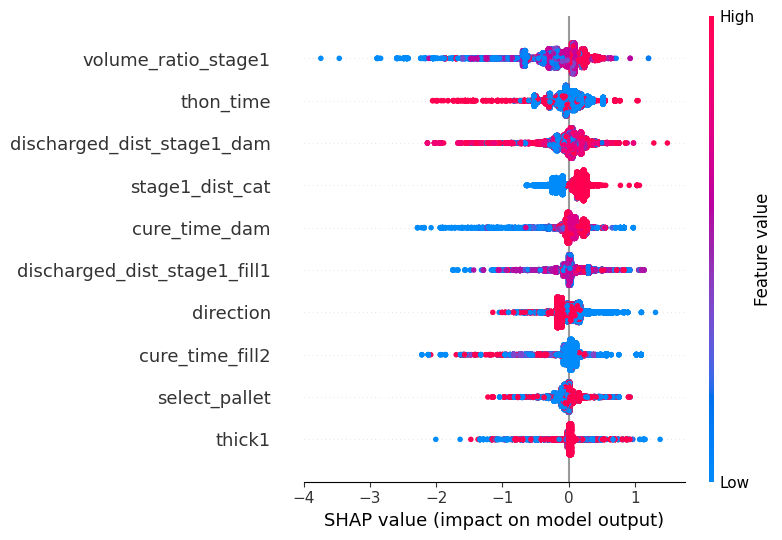

In [30]:
explainer = shap.Explainer(stage1_best_model)
shap_values = explainer(test_stage1_x)
shap.initjs()

shap.summary_plot(shap_values, test_stage1_x)

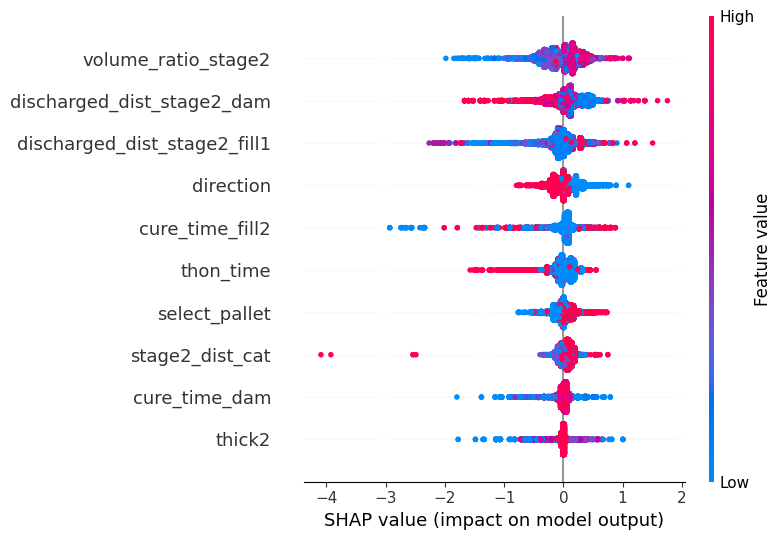

In [31]:
explainer = shap.Explainer(stage2_best_model)
shap_values = explainer(test_stage2_x)
shap.initjs()

shap.summary_plot(shap_values, test_stage2_x)

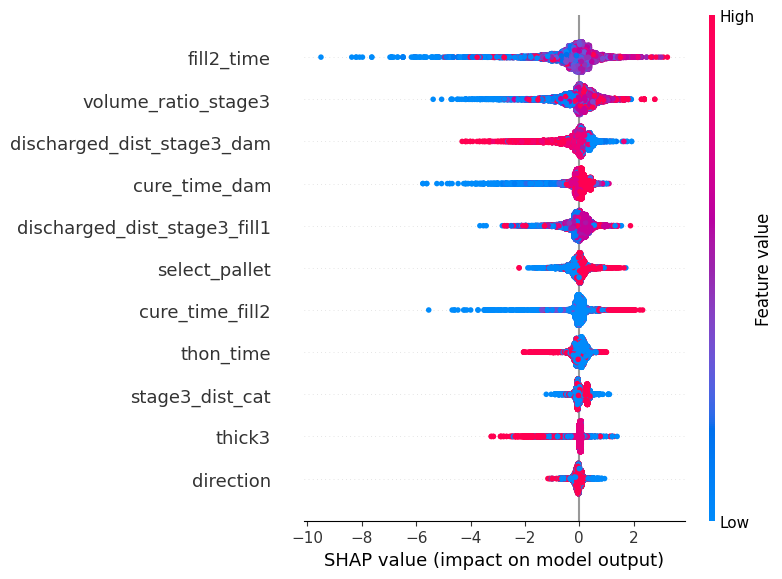

In [32]:
explainer = shap.Explainer(stage3_best_model)
shap_values = explainer(test_stage3_x)
shap.initjs()

shap.summary_plot(shap_values, test_stage3_x)

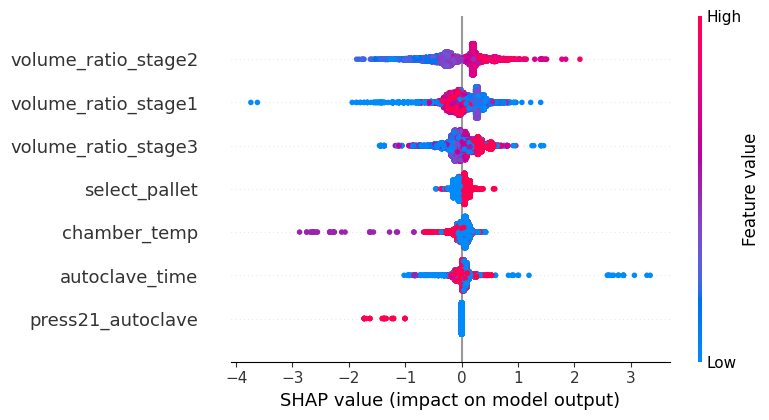

In [33]:
explainer = shap.Explainer(AutoClave_best_model)
shap_values = explainer(test_AutoClave_x)
shap.initjs()

shap.summary_plot(shap_values, test_AutoClave_x)

In [34]:
stage1_test_pred = stage1_best_model.predict(test_stage1_x)
stage1_test_pred

array([1, 0, 0, ..., 0, 0, 0])

In [35]:
stage2_test_pred = stage2_best_model.predict(test_stage2_x)
stage2_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [36]:
stage3_test_pred = stage3_best_model.predict(test_stage3_x)
stage3_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [37]:
AutoClave_test_pred = AutoClave_best_model.predict(test_AutoClave_x)
AutoClave_test_pred

array([0, 0, 0, ..., 0, 1, 0])

In [38]:
result = np.logical_or(stage1_test_pred, stage2_test_pred)
result = np.logical_or(result, stage3_test_pred)
result = np.logical_or(result, AutoClave_test_pred)

In [39]:
y_pred = np.where(result == 1, "AbNormal", "Normal")

In [40]:
np.unique(y_pred, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([ 5412, 11949]))

In [41]:
test['target'] = y_pred

In [42]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,5400,11933
1,12,16


In [43]:
test['target'] = np.where(test['inconsistant'] == 1, 'AbNormal', test['target'])

In [44]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,5400,11933
1,28,0


In [45]:
test.columns

Index(['Set ID', 'inconsistant', 'stage1_dist_cat', 'stage2_dist_cat',
       'stage3_dist_cat', 'cure_time_dam', 'cure_time_fill2',
       'press21_autoclave', 'thon_time', 'discharged_dist_stage1_dam',
       'discharged_dist_stage2_dam', 'discharged_dist_stage3_dam',
       'discharged_dist_stage1_fill1', 'discharged_dist_stage2_fill1',
       'discharged_dist_stage3_fill1', 'fill2_time', 'autoclave_time', 'qty',
       'thick1', 'thick2', 'thick3', 'chamber_temp', 'model_suffix',
       'select_workorder', 'select_pallet', 'direction', 'volume_ratio_stage1',
       'volume_ratio_stage2', 'volume_ratio_stage3', 'target'],
      dtype='object')

<Axes: >

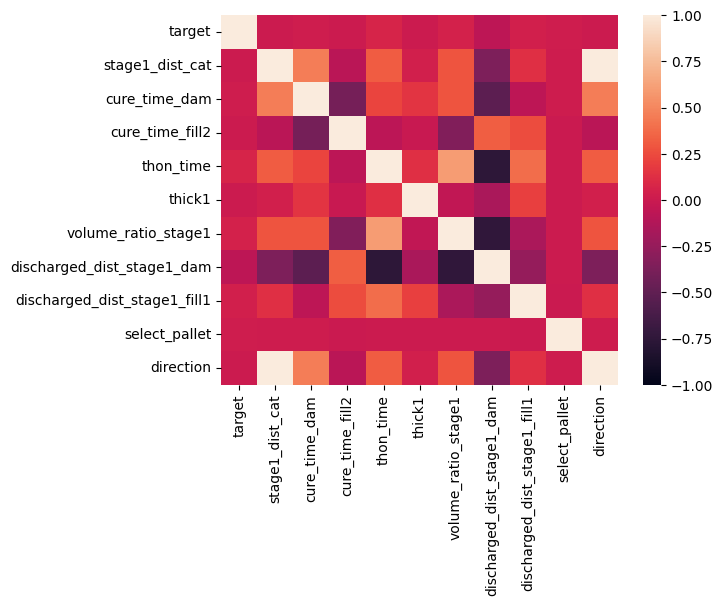

In [46]:
sns.heatmap(df_stage1.corr(), vmin=-1, vmax=1)

<Axes: >

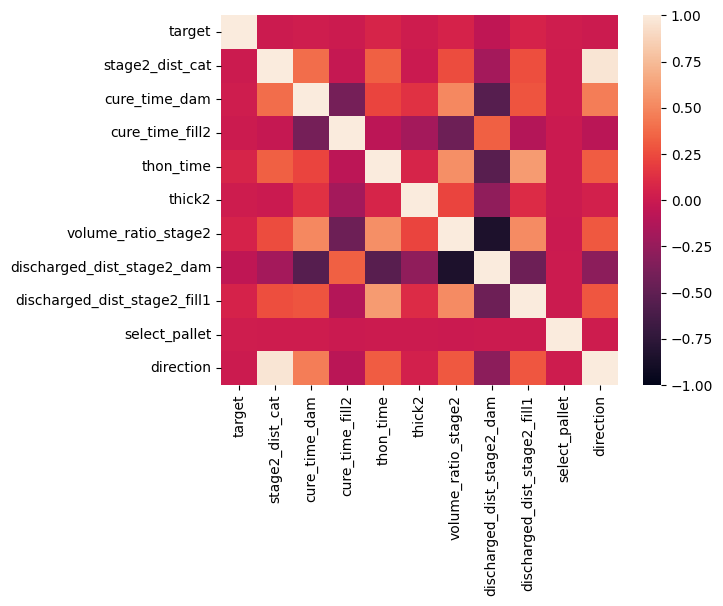

In [47]:
sns.heatmap(df_stage2.corr(), vmin=-1, vmax=1)

<Axes: >

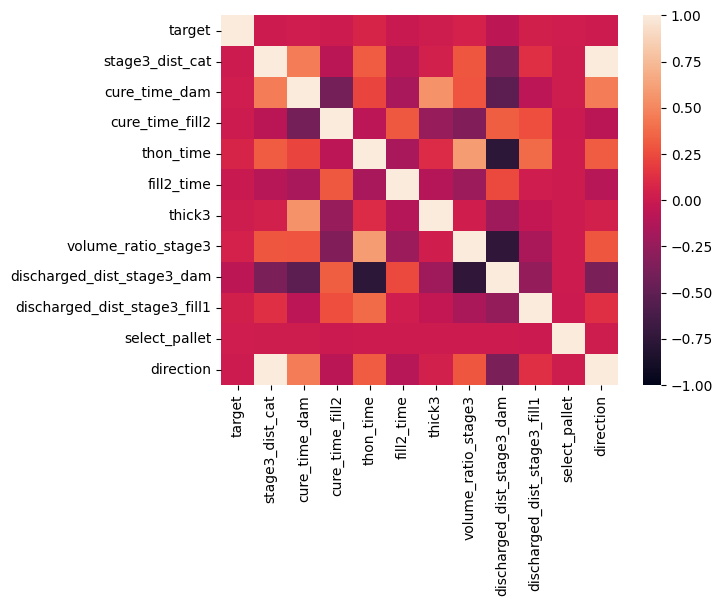

In [48]:
sns.heatmap(df_stage3.corr(), vmin=-1, vmax=1)

<Axes: >

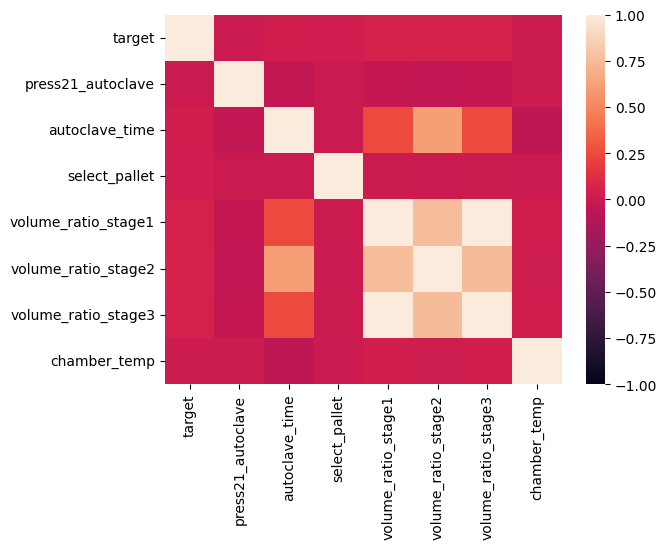

In [49]:
sns.heatmap(df_autoclave.corr(), vmin=-1, vmax=1)

<Axes: >

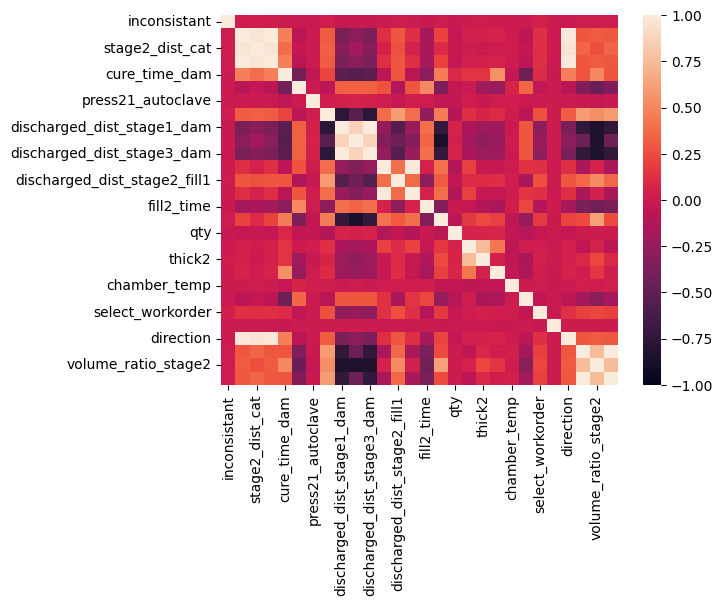

In [50]:
sns.heatmap(test.iloc[:, 1:-1].corr(), vmin=-1, vmax=1)

In [51]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = y_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)